In [1]:
"""
ULTIMATE SHAP WITH MULTI-SCALE SINGLE-PASS + DOUBLE DESCENT
============================================================

Improvements:
1. Multi-scale (1×1, 2×2, 4×4) computed in SINGLE pass per location
2. Even more extensive coverage (1000+ samples per location)
3. Option to explore double descent: train longer without early stopping
4. Focus on Transformer (better global patterns)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


# ============================================================================
# TRANSFORMER CLASSIFIER
# ============================================================================

class TransformerClassifier(nn.Module):
    """Vision Transformer for lesion classification."""
    
    def __init__(self, input_size=32, patch_size=4, embed_dim=128, num_heads=4, num_layers=3, dropout=0.1):
        super().__init__()
        
        self.patch_size = patch_size
        self.num_patches = (input_size // patch_size) ** 2
        self.embed_dim = embed_dim
        
        # Patch embedding
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        # Positional embedding
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        
        # Add positional embedding
        x = x + self.pos_embed
        
        # Transformer
        x = self.transformer(x)
        
        # Global average pooling
        x = x.mean(dim=1)
        
        # Classification
        x = self.classifier(x)
        
        return x


# ============================================================================
# DATASET
# ============================================================================

class GPUTensorDataset(Dataset):
    def __init__(self, data, labels, device):
        self.data = torch.tensor(data, dtype=torch.float32, device=device)
        self.labels = torch.tensor(labels, dtype=torch.float32, device=device)
        if self.labels.dim() == 1:
            self.labels = self.labels.unsqueeze(1)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]


# ============================================================================
# TRAINING WITH DOUBLE DESCENT OPTION
# ============================================================================

def train_transformer(
    model, 
    train_loader, 
    val_loader, 
    device, 
    epochs=300, 
    lr=1e-3,
    use_early_stopping=True,
    patience=50,
    explore_double_descent=False
):
    """
    Train with option to explore double descent.
    
    Args:
        use_early_stopping: Stop when validation loss stops improving
        explore_double_descent: Train much longer to see if overfitting helps SHAP
    """
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    if explore_double_descent:
        # Train much longer, no early stopping
        epochs = 1000
        use_early_stopping = False
        print("\n⚠️  EXPLORING DOUBLE DESCENT: Training for 1000 epochs without early stopping")
        print("   Hypothesis: Overfitting may lead to sharper, more discriminative SHAP values")
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
    criterion = nn.BCELoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    print("Training Transformer classifier...")
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for x, y in train_loader:
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += ((pred > 0.5) == y).sum().item()
            train_total += len(y)
        
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for x, y in val_loader:
                pred = model(x)
                loss = criterion(pred, y)
                val_loss += loss.item()
                val_correct += ((pred > 0.5) == y).sum().item()
                val_total += len(y)
        
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step()
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch:4d}: train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, "
                  f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}")
        
        # Early stopping (if enabled)
        if use_early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), 'best_transformer.pth')
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    # Load best model (if using early stopping)
    if use_early_stopping:
        model.load_state_dict(torch.load('best_transformer.pth'))
    else:
        # Save final model
        torch.save(model.state_dict(), 'best_transformer.pth')
    
    print("Training complete!")
    
    # Plot training curves
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(train_losses, label='Train', alpha=0.7)
    axes[0].plot(val_losses, label='Validation', alpha=0.7)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Curves: Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(train_accs, label='Train', alpha=0.7)
    axes[1].plot(val_accs, label='Validation', alpha=0.7)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training Curves: Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    if explore_double_descent:
        # Highlight potential double descent region
        if len(val_losses) > 100:
            min_idx = np.argmin(val_losses)
            axes[0].axvline(min_idx, color='red', linestyle='--', alpha=0.5, 
                          label=f'Min val loss (epoch {min_idx})')
            axes[0].legend()
    
    plt.tight_layout()
    plt.show()
    
    return model


# ============================================================================
# MULTI-SCALE SINGLE-PASS SHAP
# ============================================================================

@torch.no_grad()
def multiscale_singlepass_shap(
    model,
    lesions,
    device,
    scales=[1, 2, 4],
    scale_weights=[0.5, 0.3, 0.2],
    samples_per_location=1000,  # ignored
    batch_size=4096,
    verbose=True,
    total_masks=20000
):
    model.eval()
    torch.backends.cudnn.benchmark = True

    # lesions: numpy → tensor on GPU once
    lesions = torch.as_tensor(lesions, dtype=torch.float32, device=device)

    H, W = lesions.shape[-2:]
    N = lesions.shape[0]

    if verbose:
        print("\nFAST Multi-Scale SHAP (streaming masks)")
        print(f"total_masks={total_masks}, batch_size={batch_size}")

    # per-scale accumulators ON GPU
    shap_acc = {s: torch.zeros((1, 1, H, W), device=device) for s in scales}
    coverage = {s: torch.zeros((1, 1, H, W), device=device) for s in scales}

    # (optional) compile model
    try:
        model = torch.compile(model)
    except Exception:
        pass

    # iterate scales
    for s, w in zip(scales, scale_weights):
        m_s = int(total_masks * w)
        g_h = max(1, H // s)
        g_w = max(1, W // s)

        if verbose:
            print(f"Scale {s}: {m_s} masks")

        num_batches = (m_s + batch_size - 1) // batch_size
        iterator = tqdm(range(num_batches), disable=not verbose)

        for _ in iterator:
            B = min(batch_size, m_s)

            # on-the-fly masks → constant memory
            grid = (torch.rand((B,1,g_h,g_w), device=device) < 0.5).float()
            m = F.interpolate(grid, size=(H, W), mode="nearest")  # [B,1,H,W]

            idx = torch.randint(0, N, (B,), device=device)
            x = lesions[idx] * m  # masked lesion

            preds = model(x).view(B, 1, 1, 1)  # broadcast-friendly

            shap_acc[s] += (preds * m).sum(0, keepdim=True)
            coverage[s] += m.sum(0, keepdim=True)

            m_s -= B

    # ---------------------------------------------------------
    # Normalization + return CPU numpy
    # ---------------------------------------------------------
    shap_maps_by_scale = {}
    final_map_gpu = torch.zeros((H, W), device=device)

    for s, w in zip(scales, scale_weights):
        cov = coverage[s].clamp_min(1e-6)
        shap_s_gpu = shap_acc[s] / cov
        shap_s_gpu = shap_s_gpu.squeeze(0).squeeze(0)  # [H,W]

        # aggregate weighted final map
        final_map_gpu += w * shap_s_gpu

        # ✅ safe numpy conversion
        shap_maps_by_scale[s] = shap_s_gpu.detach().cpu().numpy()

    shap_map = final_map_gpu.detach().cpu().numpy()

    if verbose:
        print("FAST SHAP complete.")

    return shap_map, shap_maps_by_scale

# ============================================================================
# THRESHOLD CALIBRATION
# ============================================================================

def calibrate_threshold(shap_map, val_data, val_labels, model, device):
    """Calibrate threshold on validation set."""
    
    print("\n" + "="*70)
    print("CALIBRATING THRESHOLD")
    print("="*70)
    
    thresholds = np.linspace(shap_map.min(), shap_map.max(), 50)
    
    best_threshold = 0
    best_accuracy = 0
    
    for thresh in tqdm(thresholds, desc="Testing thresholds"):
        substrate_mask = (shap_map > thresh).astype(float)
        
        overlaps = []
        for lesion in val_data:
            overlap = np.sum(lesion.squeeze() * substrate_mask)
            overlaps.append(overlap)
        overlaps = np.array(overlaps)
        
        overlap_threshold = np.median(overlaps[overlaps > 0]) if np.any(overlaps > 0) else 0
        predictions = (overlaps > overlap_threshold).astype(int)
        accuracy = np.mean(predictions == val_labels)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = thresh
    
    print(f"\nBest threshold: {best_threshold:.4f}")
    print(f"Validation accuracy: {best_accuracy:.3f}")
    print(f"Substrate voxels: {np.sum(shap_map > best_threshold)}")
    print("="*70)
    
    return best_threshold


# ============================================================================
# VISUALIZATION & EVALUATION
# ============================================================================

def visualize_multiscale_results(shap_map, shap_maps_by_scale, true_substrate, threshold):
    """Visualize multi-scale SHAP results."""
    
    scales = list(shap_maps_by_scale.keys())
    n_scales = len(scales)
    
    fig, axes = plt.subplots(2, n_scales + 1, figsize=(4 * (n_scales + 1), 8))
    
    # Row 1: Per-scale SHAP maps
    for idx, scale in enumerate(scales):
        s_map = shap_maps_by_scale[scale]
        s_norm = (s_map - s_map.min()) / (s_map.max() - s_map.min() + 1e-8)
        
        im = axes[0, idx].imshow(s_norm, cmap='hot', vmin=0, vmax=1)
        axes[0, idx].set_title(f'Scale {scale}×{scale}', fontsize=11, fontweight='bold')
        axes[0, idx].axis('off')
        plt.colorbar(im, ax=axes[0, idx], fraction=0.046)
    
    # Combined SHAP
    shap_norm = (shap_map - shap_map.min()) / (shap_map.max() - shap_map.min() + 1e-8)
    im = axes[0, n_scales].imshow(shap_norm, cmap='hot', vmin=0, vmax=1)
    axes[0, n_scales].set_title('Combined\n(Weighted)', fontsize=11, fontweight='bold')
    axes[0, n_scales].axis('off')
    plt.colorbar(im, ax=axes[0, n_scales], fraction=0.046)
    
    # Row 2: Thresholded comparison
    for idx in range(n_scales):
        axes[1, idx].axis('off')  # Empty
    
    # Thresholded SHAP
    shap_binary = (shap_map > threshold).astype(float)
    im = axes[1, n_scales - 1].imshow(shap_binary, cmap='hot', vmin=0, vmax=1)
    axes[1, n_scales - 1].set_title(f'Thresholded\n(>{threshold:.3f})', fontsize=11, fontweight='bold')
    axes[1, n_scales - 1].axis('off')
    plt.colorbar(im, ax=axes[1, n_scales - 1], fraction=0.046)
    
    # True substrate
    im = axes[1, n_scales].imshow(true_substrate, cmap='hot', vmin=0, vmax=1)
    axes[1, n_scales].set_title('True Substrate', fontsize=11, fontweight='bold')
    axes[1, n_scales].axis('off')
    plt.colorbar(im, ax=axes[1, n_scales], fraction=0.046)
    
    plt.suptitle('Multi-Scale SHAP Results', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def evaluate_shap(shap_map, true_substrate, threshold):
    """Evaluate SHAP against true substrate."""
    
    shap_binary = (shap_map > threshold).astype(float)
    true_binary = (true_substrate > 0).astype(float)
    
    tp = np.sum((shap_binary == 1) & (true_binary == 1))
    fp = np.sum((shap_binary == 1) & (true_binary == 0))
    fn = np.sum((shap_binary == 0) & (true_binary == 1))
    tn = np.sum((shap_binary == 0) & (true_binary == 0))
    
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    dice = 2 * tp / (2 * tp + fp + fn + 1e-8)
    
    shap_norm = (shap_map - shap_map.min()) / (shap_map.max() - shap_map.min() + 1e-8)
    corr = np.corrcoef(shap_norm.flatten(), true_substrate.flatten())[0, 1]
    
    print("\n" + "="*70)
    print("EVALUATION")
    print("="*70)
    print(f"Correlation:  {corr:.4f}")
    print(f"Dice:         {dice:.4f}")
    print(f"F1:           {f1:.4f}")
    print(f"Precision:    {precision:.4f}")
    print(f"Recall:       {recall:.4f}")
    print("="*70)
    
    return {'correlation': corr, 'dice': dice, 'f1': f1, 'precision': precision, 'recall': recall}


# ============================================================================
# MAIN
# ============================================================================

def main(explore_double_descent=False):
    """Complete pipeline."""
    
    print("="*70)
    print("ULTIMATE SHAP: MULTI-SCALE SINGLE-PASS + DOUBLE DESCENT")
    print("="*70)
    
    # Load data
    lesions = np.load('data/toy_examples/1000_lesions.npy')
    substrate = np.load('data/toy_examples/question_mark_substrate.npy')
    
    BINARY_THRESHOLD = 0.05
    deficit_scores = []
    for i in range(len(lesions)):
        overlap = lesions[i] * substrate
        counts = np.count_nonzero(overlap)
        voxels_gt = np.sum(substrate)
        ratio_lesion = counts / voxels_gt
        deficit_scores.append(1 if ratio_lesion > BINARY_THRESHOLD else 0)
    deficit_scores = np.array(deficit_scores)
    
    if lesions.ndim == 3:
        lesions = np.expand_dims(lesions, axis=1)
    
    train_data, temp_data, train_labels, temp_labels = train_test_split(
        lesions, deficit_scores, test_size=0.3, random_state=42, stratify=deficit_scores
    )
    val_data, test_data, val_labels, test_labels = train_test_split(
        temp_data, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )
    
    print(f"\nData splits: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")
    
    # Train Transformer
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    batch_size = 32
    train_dataset = GPUTensorDataset(train_data, train_labels, device)
    val_dataset = GPUTensorDataset(val_data, val_labels, device)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = TransformerClassifier(input_size=32, patch_size=4, embed_dim=128, 
                                  num_heads=4, num_layers=3, dropout=0.1).to(device)
    
    print(f"\nTraining Transformer ({sum(p.numel() for p in model.parameters()):,} params)...")
    
    model = train_transformer(
        model, train_loader, val_loader, device,
        epochs=300,
        lr=1e-3,
        use_early_stopping=not explore_double_descent,
        explore_double_descent=explore_double_descent
    )
    
    # Multi-scale single-pass SHAP
    print("\nComputing multi-scale SHAP in single pass...")
    shap_map, shap_by_scale = multiscale_singlepass_shap(
        model,
        train_data,
        device,
        scales=[1], # [1, 2, 4],
        scale_weights=[1], # [0.5, 0.3, 0.2],
        total_masks =2**25,
        batch_size= 2**17, # 2**12
        verbose=True
    )
    
    # Calibrate threshold
    threshold = calibrate_threshold(shap_map, val_data, val_labels, model, device)
    
    # Visualize
    visualize_multiscale_results(shap_map, shap_by_scale, substrate, threshold)
    
    # Evaluate
    metrics = evaluate_shap(shap_map, substrate, threshold)
    
    print("\n" + "="*70)
    print("COMPLETE!")
    print("="*70)
    print(f"Double descent explored: {explore_double_descent}")
    print(f"Correlation: {metrics['correlation']:.4f}")
    print(f"Dice:        {metrics['dice']:.4f}")
    
    return model, shap_map, threshold, metrics



RUN 1: STANDARD TRAINING (with early stopping)
ULTIMATE SHAP: MULTI-SCALE SINGLE-PASS + DOUBLE DESCENT

Data splits: Train=700, Val=150, Test=150

Training Transformer (613,505 params)...
Training Transformer classifier...
Epoch    0: train_loss=0.6826, train_acc=0.580, val_loss=0.6849, val_acc=0.607
Epoch   50: train_loss=0.0173, train_acc=0.994, val_loss=0.3466, val_acc=0.927
Early stopping at epoch 71
Training complete!


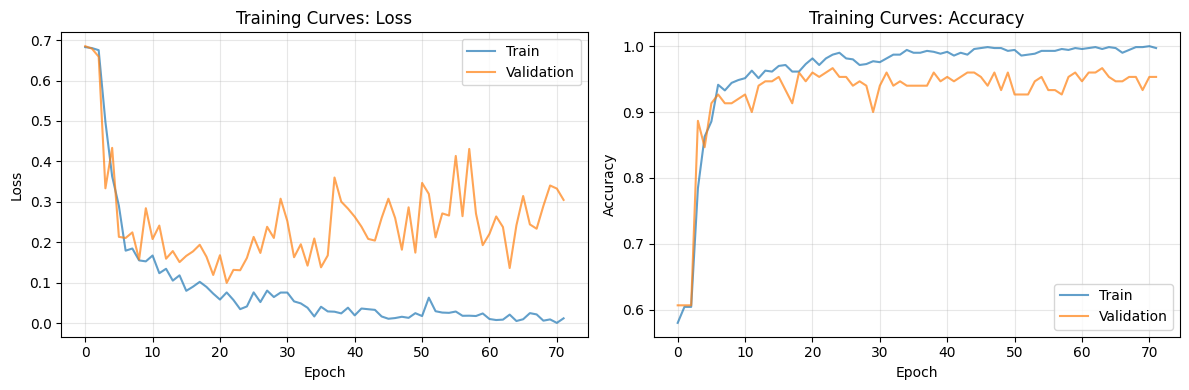


Computing multi-scale SHAP in single pass...

FAST Multi-Scale SHAP (streaming masks)
total_masks=33554432, batch_size=32768
Scale 1: 33554432 masks


100%|██████████| 1024/1024 [01:50<00:00,  9.29it/s]


FAST SHAP complete.

CALIBRATING THRESHOLD


Testing thresholds: 100%|██████████| 50/50 [00:00<00:00, 913.22it/s]


Best threshold: 0.1337
Validation accuracy: 0.907
Substrate voxels: 217


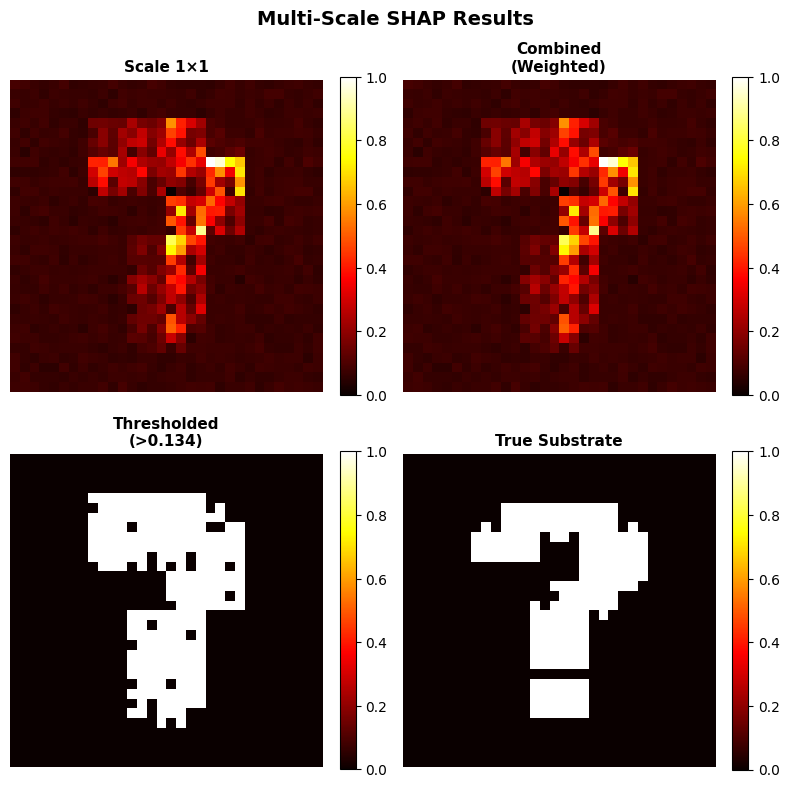


EVALUATION
Correlation:  0.6273
Dice:         0.7758
F1:           0.7758
Precision:    0.7097
Recall:       0.8556

COMPLETE!
Double descent explored: False
Correlation: 0.6273
Dice:        0.7758


In [3]:
# First: Standard training
print("\n" + "="*70)
print("RUN 1: STANDARD TRAINING (with early stopping)")
print("="*70)
model_std, shap_std, thresh_std, metrics_std = main(explore_double_descent=False)

In [2]:
def run_multi_split_experiment(
    num_splits=10,
    total_masks=2**20,
    batch_size=2**14,
    scales=[1],
    scale_weights=[1],
    explore_double_descent=False
):
    print("\n" + "="*80)
    print(f"Running {num_splits} random splits")
    print("="*80)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Load once
    lesions = np.load('data/toy_examples/1000_lesions.npy')
    substrate = np.load('data/toy_examples/question_mark_substrate.npy')

    if lesions.ndim == 3:
        lesions = lesions[:, None]

    BINARY_THRESHOLD = 0.05
    voxels_gt = np.sum(substrate)

    deficit = []
    for i in range(len(lesions)):
        overlap = lesions[i] * substrate
        ratio = np.count_nonzero(overlap) / voxels_gt
        deficit.append(1 if ratio > BINARY_THRESHOLD else 0)
    deficit = np.array(deficit)

    shap_maps = []   # collect per-split SHAP
    thresholds = []
    metrics_list = []

    for split_id in range(num_splits):
        print("\n" + "-"*80)
        print(f"Split {split_id+1}/{num_splits}")
        print("-"*80)

        # fresh split each time
        train_data, temp_data, train_labels, temp_labels = train_test_split(
            lesions, deficit, test_size=0.3, stratify=deficit,
            random_state=42 + split_id
        )
        val_data, test_data, val_labels, test_labels = train_test_split(
            temp_data, temp_labels, test_size=0.5, stratify=temp_labels,
            random_state=42 + split_id
        )

        # create model fresh each time
        model = TransformerClassifier(input_size=32, patch_size=4, embed_dim=128,
                                      num_heads=4, num_layers=3, dropout=0.1).to(device)

        # dataset loaders
        train_dataset = GPUTensorDataset(train_data, train_labels, device)
        val_dataset   = GPUTensorDataset(val_data, val_labels, device)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

        # train
        model = train_transformer(
            model, train_loader, val_loader, device,
            epochs=300, lr=1e-3,
            use_early_stopping=not explore_double_descent,
            explore_double_descent=explore_double_descent
        )

        # SHAP
        shap_map, _ = multiscale_singlepass_shap(
            model,
            train_data,
            device,
            scales=scales,
            scale_weights=scale_weights,
            total_masks=total_masks,
            batch_size=batch_size,
            verbose=True
        )

        shap_maps.append(shap_map)

        # threshold calibration on validation set
        threshold = calibrate_threshold(shap_map, val_data, val_labels, model, device)
        thresholds.append(threshold)

        # evaluate on full real substrate
        metrics = evaluate_shap(shap_map, substrate, threshold)
        metrics_list.append(metrics)

    # -----------------------------------------------------
    # Ensembled SHAP: pixel-wise average over splits
    # -----------------------------------------------------
    print("\n" + "="*80)
    print("Averaging SHAP maps across splits")
    print("="*80)

    shap_stack = np.stack(shap_maps, axis=0)  # [K, H, W]
    shap_ensemble = shap_stack.mean(axis=0)

    # average threshold for final model
    final_threshold = np.mean(thresholds)

    # evaluate final averaged map
    final_metrics = evaluate_shap(shap_ensemble, substrate, final_threshold)

    print("\nFinal ensembled SHAP metrics:")
    print(final_metrics)

    return {
        "split_shap_maps": shap_maps,
        "shap_ensemble": shap_ensemble,
        "thresholds": thresholds,
        "final_threshold": final_threshold,
        "split_metrics": metrics_list,
        "final_metrics": final_metrics
    }

In [ ]:
results = run_multi_split_experiment(
    num_splits=10,
    total_masks=2**24,
    batch_size=2**15,
    scales=[1],
    scale_weights=[1],
    explore_double_descent=False
)


Running 10 random splits

--------------------------------------------------------------------------------
Split 1/10
--------------------------------------------------------------------------------
Training Transformer classifier...
Epoch    0: train_loss=0.6747, train_acc=0.577, val_loss=0.6816, val_acc=0.607
Epoch   50: train_loss=0.0831, train_acc=0.966, val_loss=0.1840, val_acc=0.933
Early stopping at epoch 64
Training complete!


In [ ]:
substrate = np.load('data/toy_examples/question_mark_substrate.npy')

visualize_multiscale_results(results["shap_ensemble"], {"1" : results["shap_ensemble"]}, substrate, results["final_threshold"])